In [1]:
# run this at the beginning of the class to load all dependancies 
# (you can run things with Shift+Enter keyboard shortcut, or with the RUN button above)

import networkx as nx
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pprint as pp


## In this notebook

In this short notebool we will learn how to scrape links from a website. (Initially just a simple website where we load it as HTML with beautiful soup, with no need to Selenium chrome-pupeteering)

Then we will visit all the websites these links point to... and gather links from them. This way we will create a frontier and crawl/spider our way through the website and create its map.

Then we will represent that map as a simple graph.

And then we will scale the graph accordin to it's PageRank.

### But before we start: Map all the links of a website by hand. 

Visit all pages in the demo folder and on paper create a map of all the links

To view the same pages as a website: run the code below and open the link.

NOTE: if you just click the html files from the list, they will open, but all the links will not work (you will see a 403 error). So instead use below code

When you are viewing a page, remember that you can hover over a link with your mouse and you will see where that link would take you if you click it. (it usually appears on the bottom right of your web browser).

In [2]:
# this cell will print a link for you to follow:
folder_with_app_pages = "file:///" + os.getcwd() + "/demowebsite/"
starting_website = folder_with_app_pages + "home.html"

print("copy this link into another tab in your browser and visit it:")

print(starting_website)

copy this link into another tab in your browser and visit it:
file:///C:\Users\reena\OneDrive\Documents\GitHub\web-and-social-network-analytics-notes\week2-search-engines-and-traffic-prediction/demowebsite/home.html


Spend a minute drawing all the links, only by clicking in your web browser. You will end up with a spider-web style diagram. Quite often you will have to click the 'back' button, to get back to the page.

### Questions:

- Can you reach all the html files in the folder? Yes
- Are some pages dead ends? (you can't click to anywhere from them) Team is the dead end
- What page is most pointed to? And what page points to the most other pages?  shop is most pointed. Home points to most of the pages


# Let's try to automate that process. 

We will

- visit the first page and store all the links we find in it
- visit all these links in turn. But only if we have not visited them already (to avoid an infinite loop)

We'll need a function that can visit a website and 

In [3]:

def visit_page_and_return_links(page_url):
    page_url_in_a_folder  = "file:///" + os.getcwd() + "/demowebsite/" + page_url
    print(f"Looking for links in {page_url_in_a_folder}")
    
    html_of_website = urlopen(page_url_in_a_folder)
    soup = BeautifulSoup(html_of_website, 'html.parser')

    # .find_all links
    links = soup.find_all('a')
    link_urls = []
    
    # remember, links look like this: <a href="team.html">Team</a>
    # but we only care about the content of href attribute (href == 'html reference')
    for link in links:
        print('complete html of link: ', link, "\t points to ", link['href'])
        #  add every link you have to the output list       
        link_urls.append(link['href'])
    # return output list with all urls          
    return link_urls
        
    
starting_website = "home.html"
    
found_links = visit_page_and_return_links(starting_website)
print("Found links:", found_links)

Looking for links in file:///C:\Users\reena\OneDrive\Documents\GitHub\web-and-social-network-analytics-notes\week2-search-engines-and-traffic-prediction/demowebsite/home.html
complete html of link:  <a href="team.html">Team</a> 	 points to  team.html
complete html of link:  <a href="news.html">News</a> 	 points to  news.html
complete html of link:  <a href="business_deals.html">Business Deals</a> 	 points to  business_deals.html
complete html of link:  <a href="shop.html">Shop</a> 	 points to  shop.html
Found links: ['team.html', 'news.html', 'business_deals.html', 'shop.html']


Now we can write a loop that will visit all the pages. And when it visits them, will keep track of where they point. This could be done with classes, dictionaries or numpys. We'll use a list of dictionaries, but feel free to translate it into numpy.

In [4]:
# when we are done, each page info will look like this:
demo_page = {"address":"home.html", "links_to": ['team.html', 'news.html', 'business_deals.html', 'shop.html'] }

pp.pprint(demo_page) #note pp.pprint() is a 'pretty version of print'

{'address': 'home.html',
 'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']}


In [5]:
# And we will have a list of these dictionaries, like
demo_all_pages = [{'address': 'team.html', 'links_to': []},
             {'address': 'home.html',
             'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']}]

pp.pprint(demo_all_pages) 

[{'address': 'team.html', 'links_to': []},
 {'address': 'home.html',
  'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']}]


In [6]:
# let's visit our starting page, but first we'll make our function return above format of data

def visit_page_and_return_dictionary(page_url):
    #  this part is as before:   
    page_url_in_a_folder  = "file:///" + os.getcwd() + "/demowebsite/" + page_url
    print(f"Looking for links in {page_url}")
    html_of_website = urlopen(page_url_in_a_folder)
    soup = BeautifulSoup(html_of_website, 'html.parser')
    links = soup.find_all('a')
    link_urls = []
    for link in links:    
        link_urls.append(link['href'])
        
    # this is new: do not just return a list. rather, returned a structured page info     
    return {'address': page_url, 
            'links_to': link_urls}
    
starting_website = "home.html"
page_info = visit_page_and_return_dictionary(starting_website)
print()
pp.pprint(page_info)

Looking for links in home.html

{'address': 'home.html',
 'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']}


In [7]:
# now we will start two lists: Pages we have visited, and pages we have not visited yet:
# note that there are countless ways to do that.

starting_website = "home.html"

pages_we_visited = []
pages_to_visit = [starting_website] # this is new. LEt's add starting page to the pages_to_visit at first
pages_scraped_info = []

next_page_to_visit = pages_to_visit.pop() # we grab and remove the first page to visit
page_info = visit_page_and_return_dictionary(next_page_to_visit)
pages_scraped_info.append(page_info)

print("page_info", page_info)

pages_we_visited.append(page_info['address']) # we visited this page

# for all links, if they were not yet visited, add them to pages_to_visit
for link_url in page_info['links_to']:
    if link_url not in pages_we_visited:
        pages_to_visit.append(link_url)
        
print()
print("pages_we_visited", pages_we_visited)
print("pages_to_visit", pages_to_visit)
print("pages_scraped_info", pages_scraped_info)

Looking for links in home.html
page_info {'address': 'home.html', 'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']}

pages_we_visited ['home.html']
pages_to_visit ['team.html', 'news.html', 'business_deals.html', 'shop.html']
pages_scraped_info [{'address': 'home.html', 'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']}]


In [8]:
# now all we need to do is to repeat this process while there are any pages left in pages_to_visit

# this is the same
starting_website = "home.html"
pages_we_visited = []
pages_to_visit = [starting_website] 
pages_scraped_info = []

# keep repeating your code, until there are no more pages to visit
while len(pages_to_visit) > 0:
    # rest is the same
    next_page_to_visit = pages_to_visit.pop() 
    page_info = visit_page_and_return_dictionary(next_page_to_visit)
    pages_scraped_info.append(page_info)

    pages_we_visited.append(page_info['address']) 
    for link_url in page_info['links_to']:
        if link_url not in pages_we_visited:
            pages_to_visit.append(link_url)
        

        
print()
print("pages_we_visited", pages_we_visited)
print("pages_to_visit", pages_to_visit)
print("pages_scraped_info")
pp.pprint(pages_scraped_info)

Looking for links in home.html
Looking for links in shop.html
Looking for links in shop_success.html
Looking for links in business_deals.html
Looking for links in business_deals_success.html
Looking for links in news.html
Looking for links in team.html

pages_we_visited ['home.html', 'shop.html', 'shop_success.html', 'business_deals.html', 'business_deals_success.html', 'news.html', 'team.html']
pages_to_visit []
pages_scraped_info
[{'address': 'home.html',
  'links_to': ['team.html', 'news.html', 'business_deals.html', 'shop.html']},
 {'address': 'shop.html', 'links_to': ['shop_success.html']},
 {'address': 'shop_success.html', 'links_to': ['home.html']},
 {'address': 'business_deals.html',
  'links_to': ['business_deals_success.html', 'shop.html']},
 {'address': 'business_deals_success.html', 'links_to': ['home.html']},
 {'address': 'news.html', 'links_to': ['shop.html']},
 {'address': 'team.html', 'links_to': []}]


### Is this consistent with your notes that you created while manually clicking on page links?

When there are just a few pages, this process can be done manually, but as soon as you want to with no errors, and at scale (whcih is basically, always)... it is better to use software to do it for you.

# Drawing a simple graph

We will talk about graphs a bit more next week, but meanwhile I will show you a very quick one. We will use the data from our exercise above.

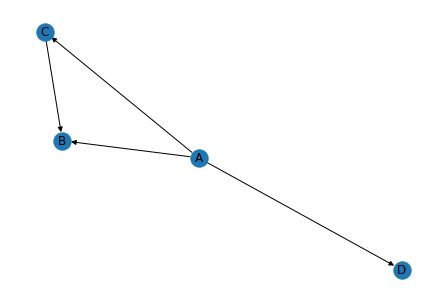

In [9]:
# create a graph
graph = nx.DiGraph()

# add some edges
graph.add_edge('A','B')
graph.add_edge('A','D')
graph.add_edge('A','C')
graph.add_edge('C','B')

# calculate 'elastic' layout
positions = nx.spring_layout(graph)

# draw the graph (you migh see a pink warning the first time. just ignore it)
nx.draw(graph, positions, with_labels=True)
plt.show()

# notice tiny arrows indicating where graphs come from and go to:

Now let's use pages_scraped_info to create a graph

Basically, for each page, we will add edges (arrows) to all the pages the page has links to.

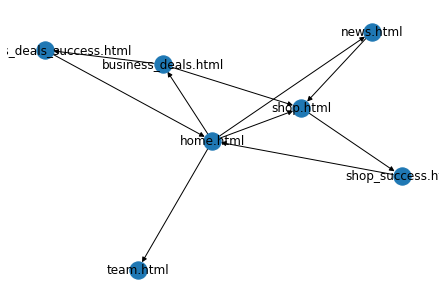

In [10]:
graph = nx.DiGraph()

# for every page we scraped
for page in pages_scraped_info:
    # take link origin (basically, that page)
    link_origin = page['address']
    all_links = page['links_to']
    # and for all pages it had links to (basically, the destinations)
    for link_destination in all_links:
        # create graph adges pointing from origin to destination
        graph.add_edge(link_origin, link_destination)

positions = nx.spring_layout(graph)
nx.draw(graph, positions, with_labels=True)
plt.show()

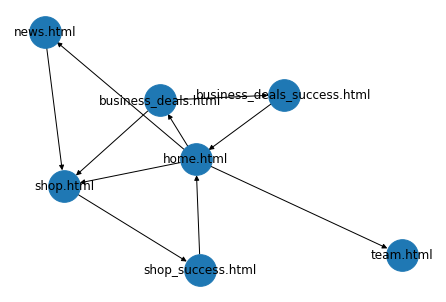

In [11]:
# let's draw it again with bigger blobs:

graph = nx.DiGraph()

for page in pages_scraped_info:
    link_origin = page['address']
    all_links = page['links_to']
    for link_destination in all_links:
        graph.add_edge(link_origin, link_destination)

positions = nx.spring_layout(graph)
nx.draw(graph, positions, with_labels=True,  node_size = 1000) # here you can set the size
plt.show()

### Are these arrows consistent with your notes that you created while manually clicking on page links?

Can you see how it could be useful to map and represent someone's web page automatically like that? And analyse it? 

### Metrics

We'll talk a bit more about metrics next week, but here is a simple measure of PageRank. We could calculate it by hand, but it would be rather time consuming.

In [12]:
pageranks = nx.pagerank(graph)

pp.pprint(pageranks)

{'business_deals.html': 0.08808412459491125,
 'business_deals_success.html': 0.06955984407083574,
 'home.html': 0.2633406825880062,
 'news.html': 0.08808412459491125,
 'shop.html': 0.20039042742686128,
 'shop_success.html': 0.20245667212956298,
 'team.html': 0.08808412459491125}


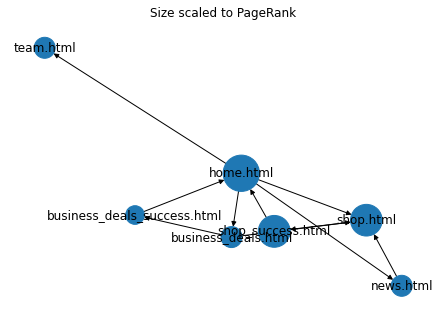

In [13]:
positions = nx.spring_layout(graph)

size = [pagerank * 5000 for pagerank in pageranks.values()]

nx.draw(graph, positions, with_labels= True, node_size = size)
plt.title("Size scaled to PageRank")
plt.show()

# Think about it: 

- What can you say about this website, knowing all the links and their page ranks? 
- Is this a good outcome? Is that there you would like your users to be?
- how would you change the links structure to e.g. increase amount of predicted traffic to business_deals.html ?


# Mini Task:

If you feel adventurous try to implement your suggestions from above - edit the html files to add/remove links, and then re-run this notebook from the top. Did you achieve the task you wanted to?

### Note about editing htmls files in jupyter:

If you'd like to view and edit html of these pages, you can go to your list of files in Jupyter. In there in the folder called `demowebsite` you will find a set of html pages: **to view and edit them as html: tick the ckeckbox next to a file and select 'edit' button on top of the screen**
